## UFood Marketing Data Analysis

In [1402]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option('display.max.columns', 40)
# pd.set_option('display.max.rows', 2300)

file = '/Users/ryanbrockhoff/Documents/Python/Pandas/Projects/u_food_marketing.csv'

food_df_raw = pd.read_csv(file)
food_df = pd.read_csv(file)

# remove duplicates
food_df.drop_duplicates(inplace=True)

# combine children input into one column.
food_df['total_children'] = food_df[['Kidhome', 'Teenhome']].sum(axis=1)


# combine marriage status columns into marital_status column
conditions = [
    (food_df['marital_Divorced'] == 1),
    (food_df['marital_Married'] == 1),
    (food_df['marital_Single'] == 1),
    (food_df['marital_Together'] == 1),
    (food_df['marital_Widow'] == 1)
]

values = ['divorced', 'married', 'single', 'together', 'widow']


food_df['marital_status'] = np.select(conditions, values, default = None)


food_df.drop(columns=['marital_Divorced', 'marital_Married', 'marital_Single', 'marital_Together', 'marital_Widow'], inplace=True)

# combine education status columns into education_status column
conditions = [
    (food_df['education_Basic'] == 1),
    (food_df['education_Graduation'] == 1),
    (food_df['education_Master'] == 1),
    (food_df['education_PhD'] == 1),
]

values = ['basic', 'graduation', 'master', 'phd']

food_df['education_level'] = np.select(conditions, values, default = None)

food_df.drop(columns=['education_Basic', 'education_Graduation', 'education_Master', 'education_PhD'], inplace = True)

# yes/no boolean based on accepting marketing campaigns: accepted_campaigns
# creates a boolean based on if equal to 0, converst to int type
food_df['accepted_campaigns'] = (food_df['AcceptedCmpOverall'] != 0).astype(int)

#### Correlations

In [ ]:
# explore correlations with users who accepted any campaign with other columns
all_camp_correlations = pd.DataFrame(food_df.corr(numeric_only=True)['accepted_campaigns'])

# filter where correlation is comparing to itself and low correlation values
high_camp_correlations = all_camp_correlations[(all_camp_correlations > 0.3) & (all_camp_correlations < 1)]

# remove null values for non-integer columns
high_camp_correlations.dropna(inplace=True)

high_camp_correlations.sort_values(by = 'accepted_campaigns', ascending=False, inplace=True)

# correlations for accepted campaigns (1-5)
campaign_correlations = high_camp_correlations[high_camp_correlations.index.str.contains('Accepted')].drop('AcceptedCmpOverall', axis=0)

# split correlations based on campaigns and other alternative factors
factor_correlations = high_camp_correlations[~high_camp_correlations.index.str.contains('Accepted')]

#### Campaign Acceptance Factors

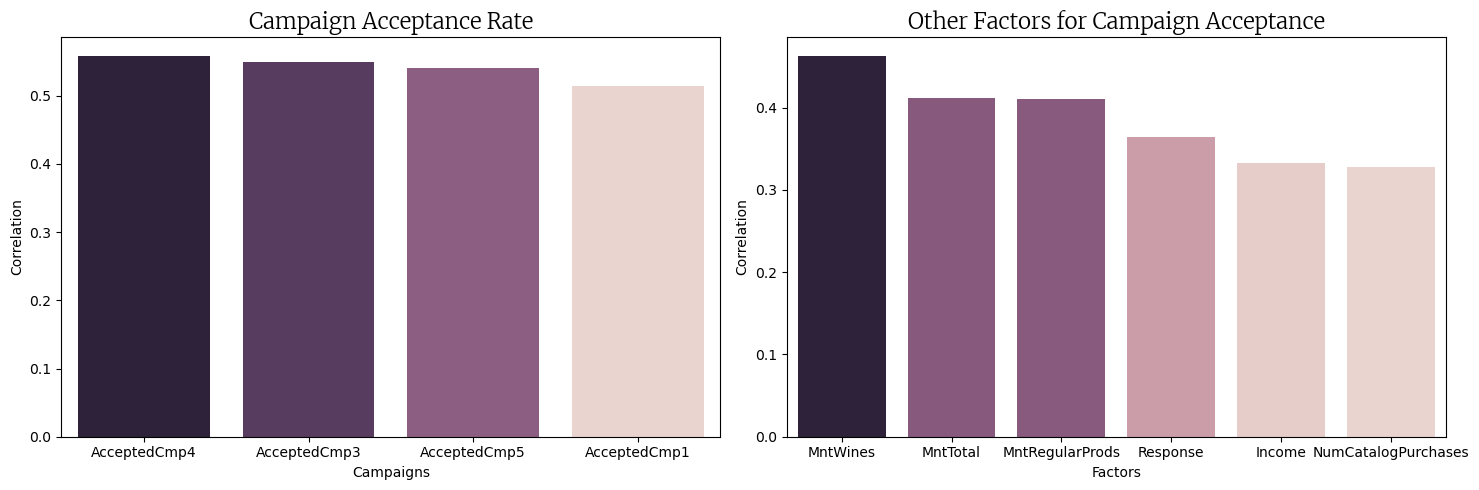

In [1406]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))

sns.barplot(data = campaign_correlations, 
            x = campaign_correlations.index, 
            y = 'accepted_campaigns', 
            ax = axes[0], 
            hue='accepted_campaigns',
            legend=False)

sns.barplot(data = factor_correlations, 
            x = factor_correlations.index, 
            y = 'accepted_campaigns', 
            ax = axes[1],
            hue='accepted_campaigns',
            legend=False)

axes[0].set_title('Campaign Acceptance Rate', fontfamily = 'Merriweather', fontsize = 16)
axes[0].set_xlabel('Campaigns')
axes[0].set_ylabel('Correlation')
# axes[0].text(-.5, -.2, 'Campaign, 3, 4, and 5 show the strongest relationship to campaign acceptance. \nWhile Campaign 2 had the weakest relationship to a customer accepting a campaign.', transform=axes[0].transAxes,  ha='left', va='baseline')

axes[1].set_title('Other Factors for Campaign Acceptance', fontfamily = 'Merriweather', fontsize = 16)
axes[1].set_xlabel('Factors')
axes[1].set_ylabel('Correlation')
# axes[1].text(-.5, -.2, 'Campaign, 3, 4, and 5 show the strongest relationship to campaign acceptance. \nWhile Campaign 2 had the weakest relationship to a customer accepting a campaign.', transform=axes[1].transAxes,  ha='left', va='baseline')

plt.tight_layout()
plt.show()
fig.savefig('/Users/ryanbrockhoff/Desktop/campaign_subplots.png', dpi=300)

#### Create Age Groups for Segmentation

In [1410]:
# Age range of 23-80 years old.

# food_df['Age'].min()
# food_df['Age'].max()

age_groups = [(23,30), (31, 40), (41, 50), (51, 60), (61, 70), (71, 81)]

def assign_age_group(age):
    for group in age_groups:
        if (age >= group[0]) & (age <= group[1]):
            return '{0} - {1}'.format(group[0], group[1])
    return None
    
food_df['age_group'] = food_df['Age'].apply(assign_age_group)

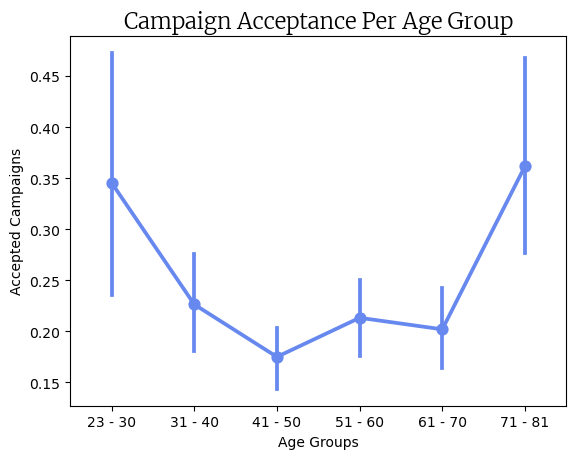

In [1416]:

pointplot_age_groups = sns.pointplot(data = food_df.sort_values(by = 'age_group'), 
              x = 'age_group',
              y='accepted_campaigns')

plt.title('Campaign Acceptance Per Age Group', fontfamily = 'Merriweather', fontsize = 16)
plt.xlabel('Age Groups')
plt.ylabel('Accepted Campaigns')

plt.show()

#### Acceptance Dataframe with Age Group Data

In [552]:
# filter to customers who accepted campaigns
accepted_campaign_df = food_df[food_df['accepted_campaigns'] >= 1]

# get total number of customers per age group
accepted_per_group = pd.DataFrame(accepted_campaign_df.groupby('age_group').size())

# total number of people in each age group - regardless of campaign acceptance
total_group_size = pd.DataFrame(food_df.groupby('age_group').size())

acceptance_df = accepted_per_group.join(total_group_size, 
                                 on='age_group', 
                                 lsuffix = '_accepted', 
                                 rsuffix = '_total')

acceptance_df.columns = ['accepted_campaigns', 'total_count']

# percentage of customers accepting campaigns per age group
acceptance_df['accepted_percentage'] = (acceptance_df['accepted_campaigns'] / 
                                        acceptance_df['total_count']).round(2) * 100

# total amount spent per age group
acceptance_df['total_spent'] = accepted_campaign_df.groupby('age_group')['MntTotal'].mean()

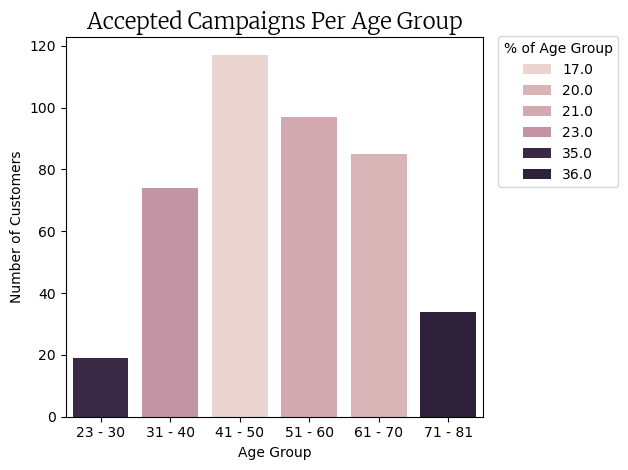

In [1270]:
sns.barplot(data = acceptance_df,
            x = 'age_group',
            y = 'accepted_campaigns',
            hue = 'accepted_percentage',
            legend = True)

plt.title('Accepted Campaigns Per Age Group', fontfamily = 'Merriweather', fontsize = 16)
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.legend(title='% of Age Group', bbox_to_anchor=(1.02, 1.02), loc='upper left')
plt.tight_layout()
plt.show()

41-50 are accepting the most campaigns overall, but have a lower conversion rate. Whereas 31-40, 41-50, and 51-60 age groups have a much better conversion rate while still having similar numbers of customers accepting campaigns. Meanwhile, our 23-30 and 71-81 age groups have a higher conversion rate for campaigns, but far fewer customers fall in these age brackets.

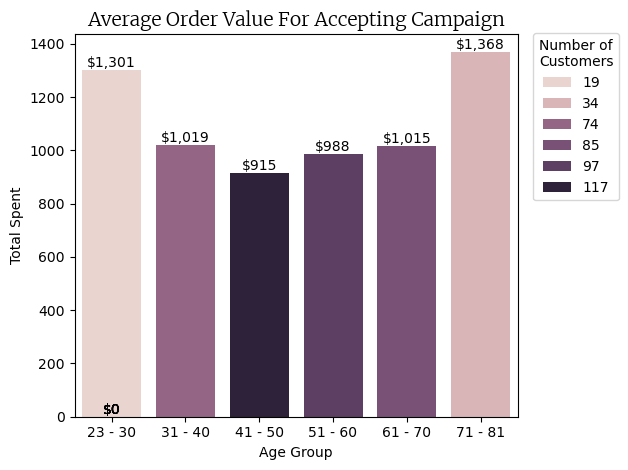

In [1540]:
ax = sns.barplot(data = acceptance_df,
            x = 'age_group',
            y = 'total_spent',
            hue='accepted_campaigns',
            legend = True)

# Add annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.0f}', # format into currency with no decimal places shown
                (p.get_x() + p.get_width() / 2., p.get_height()),  # position
                ha='center', va='center',
                fontsize=10, 
                xytext=(0, 5), textcoords='offset points')  #spacing


plt.title('Average Order Value For Accepting Campaign', fontfamily = 'Merriweather', fontsize = 14)
plt.xlabel('Age Group')
plt.ylabel('Total Spent')
plt.legend(title='Number of\nCustomers', bbox_to_anchor=(1.02, 1.02), loc='upper left')
plt.tight_layout()
plt.savefig('/Users/ryanbrockhoff/Desktop/average-order-value.png', dpi=300)
plt.show()

Average order value doesn't seem to have a strong relationship with age groups for segmentation. Average spent is comparable for age groups where we have a larger total number of customers. Small population size may be skewing results for 23-30 and 71-81.

#### Purchase Methods Dataframe 

In [644]:
purchase_columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

not_accepted_df = food_df[food_df['accepted_campaigns'] == 0]
accepted_df = food_df[food_df['accepted_campaigns'] >= 1]

# method totals for non-campaign customers
all_purchases_df = pd.DataFrame(not_accepted_df[purchase_columns].sum())

all_purchases_df.reset_index(inplace=True)
all_purchases_df.columns = ['purchase_method', 'count']
all_purchases_df.sort_values(by = 'count', ascending = False, inplace = True)

all_purchases_df['purchase_method'] = all_purchases_df['purchase_method'].str.replace('Num', '')

# method total for customers accepting campaigns
purchases_df = pd.DataFrame(accepted_df[purchase_columns].sum())

purchases_df.reset_index(inplace=True)
purchases_df.columns = ['purchase_method', 'count']
purchases_df.sort_values(by = 'count', ascending = False, inplace = True)

purchases_df['purchase_method'] = purchases_df['purchase_method'].str.replace('Num', '')

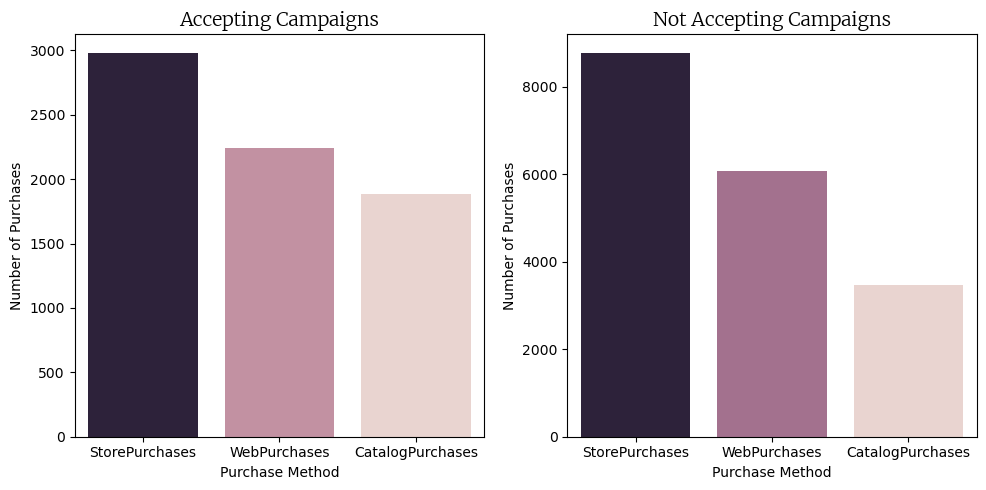

In [1322]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

sns.barplot(data = purchases_df, x='purchase_method', y = 'count', ax=axes[0], hue="count", legend=False)

sns.barplot(data = all_purchases_df, x='purchase_method', y = 'count', ax=axes[1], hue="count", legend=False)


axes[0].set_title('Accepting Campaigns', fontfamily = 'Merriweather', fontsize = 14)
axes[0].set_xlabel('Purchase Method')
axes[0].set_ylabel('Number of Purchases')

axes[1].set_title('Not Accepting Campaigns', fontfamily = 'Merriweather', fontsize = 14)
axes[1].set_xlabel('Purchase Method')
axes[1].set_ylabel('Number of Purchases')

plt.tight_layout()
plt.show()

Customers accepting marketing campaigns made 8% more catalog purchases, while store and website purchases remain consistent.

In [ ]:
# calculate percentage increase in catalog purchases based on campaign acceptance

camp_catalog_count = purchases_df[purchases_df['purchase_method'] == 'CatalogPurchases']['count'].iloc[0]
all_catalog_count = all_purchases_df[all_purchases_df['purchase_method'] == 'CatalogPurchases']['count'].iloc[0]

# 27% for those who accepted campaigns
camp_catalog_percentage = (camp_catalog_count / purchases_df['count'].sum()).round(2) * 100

# 19% for those who did not accept campaigns
no_camp_catalog_percentage = (all_catalog_count / all_purchases_df['count'].sum()).round(2) * 100

#### Web Traffic Conversion

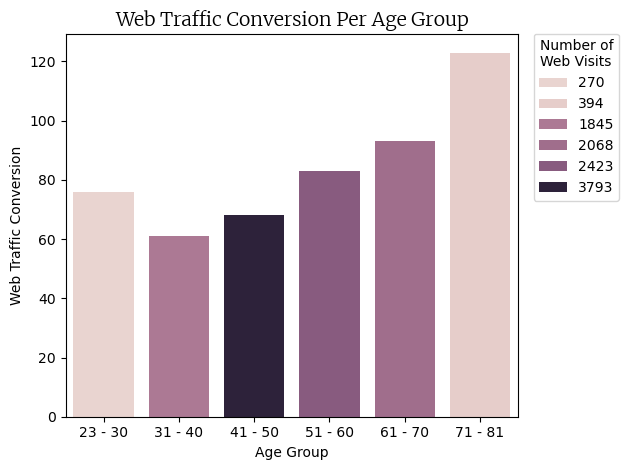

In [1544]:
web_conversion_df = food_df[['NumWebVisitsMonth', 'NumWebPurchases', 'age_group']].groupby('age_group').sum().round(2)

web_conversion_df.reset_index(inplace = True)

web_conversion_df['web_traffic_conversion'] = (web_conversion_df['NumWebPurchases'] / web_conversion_df['NumWebVisitsMonth']).round(2) * 100

web_conversion_df

sns.barplot(data = web_conversion_df, x = 'age_group', y = 'web_traffic_conversion', hue='NumWebVisitsMonth')

plt.title('Web Traffic Conversion Per Age Group', fontfamily = 'Merriweather', fontsize = 14)
plt.xlabel('Age Group')
plt.ylabel('Web Traffic Conversion')

plt.legend(title='Number of\nWeb Visits', bbox_to_anchor=(1.02, 1.02), loc='upper left')
plt.tight_layout()
plt.show()

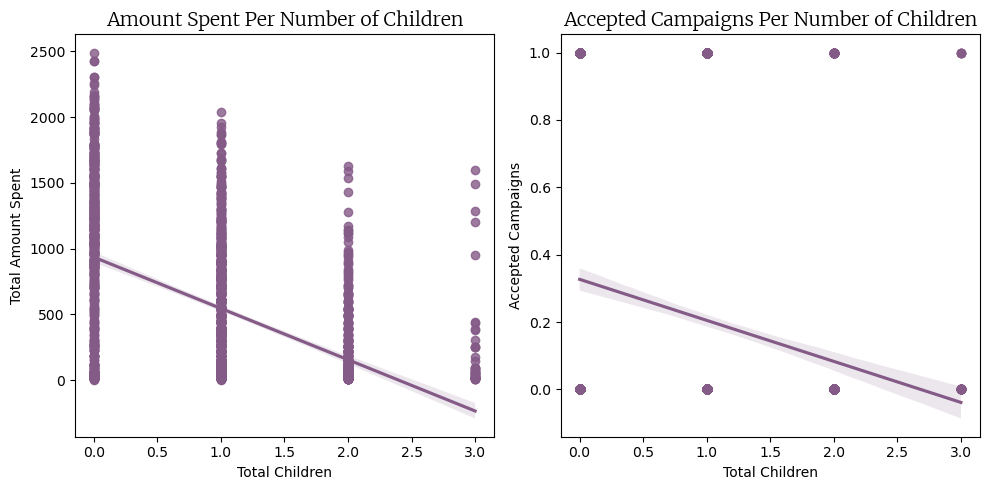

In [1512]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))


sns.regplot(data = food_df, x = 'total_children', y = 'MntTotal', ax = axes[0], color = '#845A87')
sns.regplot(data = food_df, x = 'total_children', y = 'accepted_campaigns', ax = axes[1], color = '#845A87')

axes[0].set_title('Amount Spent Per Number of Children', fontfamily = 'Merriweather', fontsize = 14)
axes[0].set_xlabel('Total Children')
axes[0].set_ylabel('Total Amount Spent')

axes[1].set_title('Accepted Campaigns Per Number of Children', fontfamily = 'Merriweather', fontsize = 14)
axes[1].set_xlabel('Total Children')
axes[1].set_ylabel('Accepted Campaigns')


plt.tight_layout()
plt.show()

The fewer children a customer has, the more likely they are to spend more and accept campaigns.

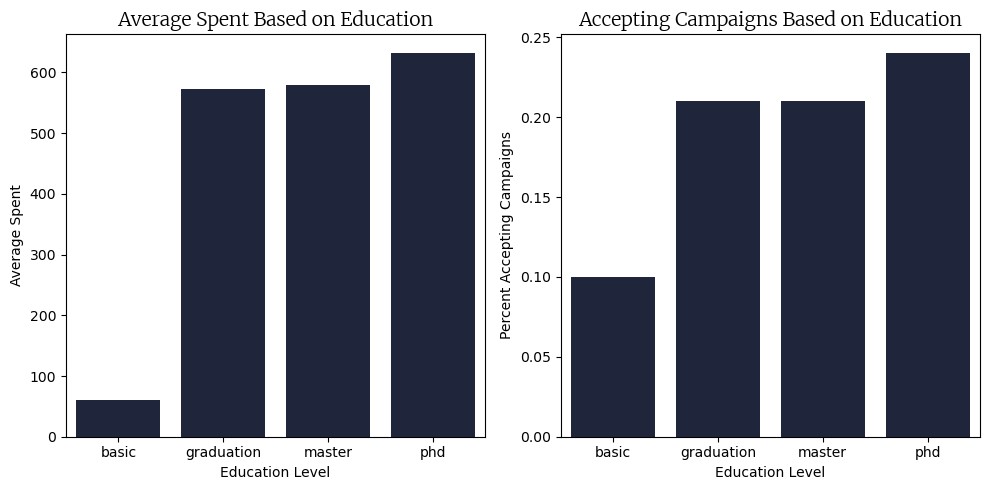

In [1522]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

education_df = pd.DataFrame(food_df.groupby('education_level')[['MntTotal', 'accepted_campaigns']].mean().round(2))

education_df.reset_index(inplace = True)
education_df.columns = ['education_level', 'sum_spent', 'accepted_campaigns']

sns.barplot(data = education_df, x = 'education_level', y = 'sum_spent', ax= axes[0])

axes[0].set_title('Average Spent Based on Education', fontfamily = 'Merriweather', fontsize = 14)
axes[0].set_xlabel('Education Level')
axes[0].set_ylabel('Average Spent')

sns.barplot(data = education_df, x = 'education_level', y = 'accepted_campaigns', ax= axes[1])
axes[1].set_title('Accepting Campaigns Based on Education', fontfamily = 'Merriweather', fontsize = 14)
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel('Percent Accepting Campaigns')

plt.tight_layout()
plt.show()

Those with a basic education level have a low average order value and accept significaly fewer campaigns. Whereas all other education levels have a comparable order value and campaign acceptance.

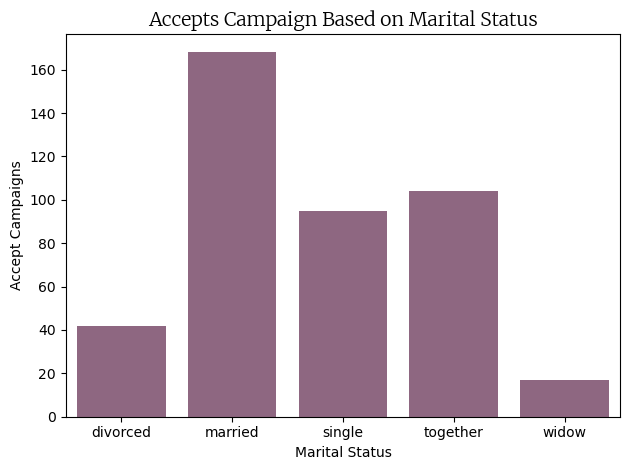

In [1534]:
marital_df = food_df[['marital_status', 'MntTotal', 'accepted_campaigns']].groupby('marital_status').sum()

marital_df.reset_index(inplace = True)

sns.barplot(data = marital_df, x = 'marital_status', y = 'accepted_campaigns', color = '#946083')

plt.title('Accepts Campaign Based on Marital Status', fontfamily = 'Merriweather', fontsize = 14)
plt.xlabel('Marital Status')
plt.ylabel('Accept Campaigns')
plt.tight_layout()
plt.savefig('/Users/ryanbrockhoff/Desktop/marital-status-demographics.png', dpi=300)
plt.show()

Married customers accept significantly more campaigns than other demographics, with similar results found in total spent.

#### Top Performing Segmentations

In [1250]:
initial_segments = food_df[['MntTotal', 'accepted_campaigns', 
                'marital_status', 'total_children', 'education_level', 
                'age_group']].groupby(['marital_status', 'total_children', 'education_level', 'age_group']).sum()

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)

initial_segments.sort_values(by = ['MntTotal', 'accepted_campaigns'], ascending = False, inplace = True)

top_five_segment = initial_segments.iloc[:5]

In [1252]:
# merge multi-level index values together and reset as new index for top 5 performing segments
combined_index = []

for item in top_five_segment.index:
    string_text = ''
    for inner_text in item:
        string_text += ('\n' + str(inner_text))
    combined_index.append(string_text.strip())

# Reset the index of top_five_segment to allow reindexing
top_five_segment.reset_index(drop=True, inplace=True)

# Assign the combined index as the new index
top_five_combined = top_five_segment.copy()
top_five_combined['combined_index'] = combined_index

# Set the 'combined_index' as the new index
top_five_combined.set_index('combined_index', inplace=True)

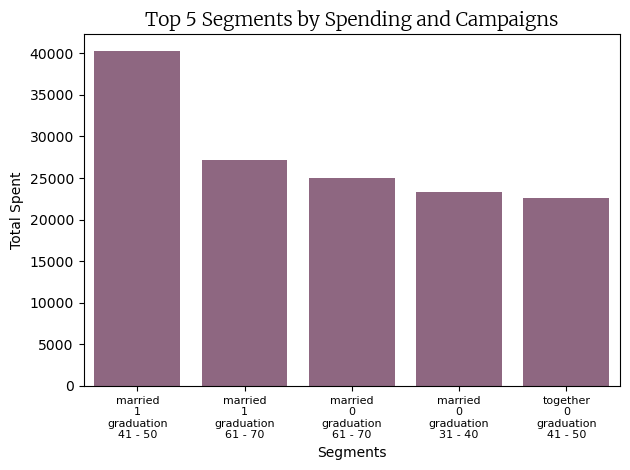

In [1532]:
top_five_combined.sort_values(by = 'MntTotal', ascending = False, inplace = True)

# plot chart
sns.barplot(data = top_five_combined, x = 'combined_index', y = 'MntTotal', color = '#946083')

plt.title('Top 5 Segments by Spending and Campaigns', fontfamily = 'Merriweather', fontsize = 14)
plt.xticks(fontsize = 8)
plt.xlabel('Segments')
plt.ylabel('Total Spent')

plt.tight_layout()
plt.savefig('/Users/ryanbrockhoff/Desktop/marital-status-demographics.png', dpi=300)
plt.show()

Customers that are married, who have graduated, and have 0-1 children make up the majority of our top spending customers. The married, 1 child, graduated, 41-50 age segment spends significantly more and accept more campaigns than others segmentations. 